# Biofouling of Dissolved Oxygen Sensors
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on Aug 5, 2020. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download Dissolved Oxygen data from the Endurance Washington Offshore Surface Mooring using the Machine-to-Machine (M2M) interface, create quick plots, identify evidence of biofouling, and export the data as .csv files.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from geopy.distance import geodesic

## Request Data from OOINet

**Coastal Endurance Oregon Offshore Surface Mooring (CE04OSSM)**
* Dissolved Oxygen sensor (deployed at 7m)
    * Instrument: CE04OSSM-RID27-04-DOSTAD000
    * Data stream: dosta_abcdjm_dcl_instrument_recovered
    * Parameter: estimated_oxygen_concentration
* Time ranges
    * 2017-04-20 to 2017-10-01: Deployment 4, before implementation of biofouling mitigation
    * 2019-04-20 to 2019-10-01: Deployment 8, after implementation of biofouling mitigation
* Delivery method: recovered_host

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/extras'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for these instruments. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# DO2017_url = request_data('CE04OSSM-RID27-04-DOSTAD000', 'recovered_host', 'dosta_abcdjm_dcl_instrument_recovered',
#                           '2017-04-22T00:00:00.000Z', '2017-10-01T00:00:00.000Z')

# DO2019_url = request_data('CE04OSSM-RID27-04-DOSTAD000', 'recovered_host', 'dosta_abcdjm_dcl_instrument_recovered',
#                           '2019-04-22T00:00:00.000Z', '2019-10-01T00:00:00.000Z')

# print('DO2017_url = %s' %DO2017_url)
# print('DO2019_url = %s' %DO2019_url)

DO2017_url = https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200805T153719574Z-CE04OSSM-RID27-04-DOSTAD000-recovered_host-dosta_abcdjm_dcl_instrument_recovered/catalog.html
DO2019_url = https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200805T153719849Z-CE04OSSM-RID27-04-DOSTAD000-recovered_host-dosta_abcdjm_dcl_instrument_recovered/catalog.html


## Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
DO2017_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200805T153719574Z-CE04OSSM-RID27-04-DOSTAD000-recovered_host-dosta_abcdjm_dcl_instrument_recovered/catalog.html'
DO2019_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200805T153719849Z-CE04OSSM-RID27-04-DOSTAD000-recovered_host-dosta_abcdjm_dcl_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        if 'ADCPS' in ds.sensor:
            # determine the number of bins to which time stamps need to be applied
            varlength = len(ds['bin_depths'].values.T)
            data_dict['time'] = np.append(data_dict['time'], np.repeat(ds['time'].values, varlength, axis=0))
        else:
            data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            if 'ADCPS' in ds.sensor:
                data_dict[var] = np.append(data_dict[var], ds[var].values.flatten())
            else:
                data_dict[var] = np.append(data_dict[var], ds[var].values)
            try:
                units = ds[var].units
                if units not in unit_dict[var]:
                    unit_dict[var].append(units)
            except AttributeError:
                continue

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

In [7]:
# Specify the variables of interest and get the data
DOvars = ['estimated_oxygen_concentration']

DO2017_data, DO2017_units = get_data(DO2017_url, DOvars)
DO2019_data, DO2019_units = get_data(DO2019_url, DOvars)

print(DO2019_units)

Appending data from files
Appending data from files
{'estimated_oxygen_concentration': ['µmol L-1']}


In [8]:
# print out the first few lines of each dataset
DO2017_data.head()

,time,estimated_oxygen_concentration
0,2017-04-22 00:00:16.576000000,344.825989
1,2017-04-22 00:00:16.581000192,344.835999
2,2017-04-22 00:00:18.472000000,344.898987
3,2017-04-22 00:00:20.470999552,344.799011
4,2017-04-22 00:00:22.470999552,344.782990


In [9]:
DO2019_data.head()

,time,estimated_oxygen_concentration
0,2019-04-22 00:00:12.946999808,344.644012
1,2019-04-22 00:00:14.972000256,344.752991
2,2019-04-22 00:00:16.947999744,344.717010
3,2019-04-22 00:00:18.946999808,344.612000
4,2019-04-22 00:00:20.947999744,344.700989


Since these data are collected every 2 seconds, we will downsample the datasets a little later to make the .csv files more manageable. But first, let's make some quick timeseries plots to make sure we have the correct data.

## Quick Data Plots

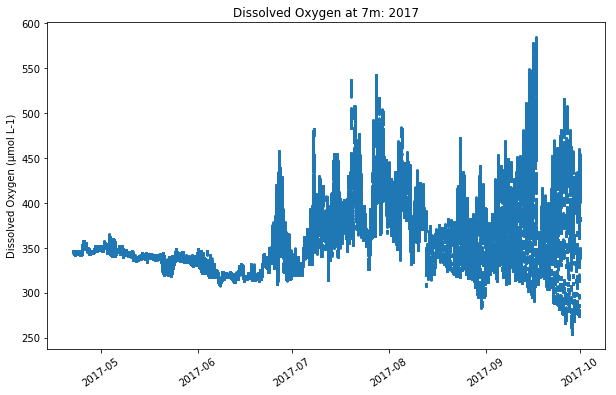

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DO2017_data['time'], DO2017_data['estimated_oxygen_concentration'], '.', markersize=3)
ax.set_title('Dissolved Oxygen at 7m: 2017')
ax.set_ylabel('Dissolved Oxygen ({})'.format(DO2017_units['estimated_oxygen_concentration'][0]))

# rotate x tick labels
plt.xticks(rotation=35);

The DO values at the beginning of this spring deployment appear reasonable. After a few months, however, the values become unreasonably variable and some maximum values are really high. First, let's look at the global ranges for this sensor to see if we can tell if some of these values are too high to be real. Here is a function to return the global ranges for this instrument using the OOI API: 

In [11]:
def get_global_ranges(refdes, variable, api_user, api_token):
    port = '12578'
    spl = refdes.split('-')
    base_url = '{}/qcparameters/inv/{}/{}/{}/'.format(port, spl[0], spl[1], '-'.join((spl[2], spl[3])))
    url = 'https://ooinet.oceanobservatories.org/api/m2m/{}'.format(base_url)
    r = requests.get(url, auth=(api_user, api_token), verify=True)
    
    if r.status_code is 200:
        if r.json():  # If r.json is not empty
            values = pd.io.json.json_normalize(r.json())
            t1 = values[values['qcParameterPK.streamParameter'] == variable]
            if not t1.empty:
                t2 = t1[t1['qcParameterPK.qcId'] == 'dataqc_globalrangetest_minmax']
                if not t2.empty:
                    global_min = float(t2[t2['qcParameterPK.parameter'] == 'dat_min'].iloc[0]['value'])
                    global_max = float(t2[t2['qcParameterPK.parameter'] == 'dat_max'].iloc[0]['value'])
                else:
                    global_min = None
                    global_max = None
            else:
                global_min = None
                global_max = None
        else:
            global_min = None
            global_max = None
    else:
        print('uFrame is not responding to request for global ranges. Try again later.')

    return [global_min, global_max]

In [12]:
DO_global_min, DO_global_max = get_global_ranges('CE04OSSM-RID27-04-DOSTAD000', 'estimated_oxygen_concentration', 
                                                 API_USERNAME, API_TOKEN)
print('DO_global_min = {}'.format(DO_global_min))
print('DO_global_max = {}'.format(DO_global_max))

DO_global_min = 0.0
DO_global_max = 400.0


The data ranges starting in the end of June are outside of global ranges, so these data are unreasonable. Let's also look at the annotations in the system for this instrument to see if the operators noted anything for this time period via the annotation API. Note: you can also download the annotations.json included with your data download in the THREDDS server.

In [13]:
def annotations(refdes):
    ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
    params = {'refdes': refdes}

    r = requests.get(ANNO_API, params=params, auth=(API_USERNAME, API_TOKEN))
    anno_data = r.json()

    anno_df = pd.DataFrame()  # Setup empty array
    for ad in anno_data:
        start = dt.datetime.utcfromtimestamp(ad['beginDT'] / 1000)
        try:
            stop = dt.datetime.utcfromtimestamp(ad['endDT']/1000)
        except TypeError:
            stop = ad['endDT']
        anno_df = anno_df.append({
            'annotation': ad['annotation'],
            'start': start,
            'stop': stop,
            'site': ad['subsite'],
            'node': ad['node'],
            'sensor': ad['sensor'],
            'id': ad['id']
        }, ignore_index=True)
    pd.set_option('display.max_colwidth', -1)  # Show the full annotation text
    return anno_df

In [14]:
anno = annotations('CE04OSSM-RID27-04-DOSTAD000')
anno

,annotation,id,node,sensor,site,start,stop
0,The use of UV lamps has been implemented for biofouling mitigation on this instrument as of 2018-04-03T18:16:00Z.,2113.0,RID27,04-DOSTAD000,CE04OSSM,2018-04-03 18:16:00,None
1,"Prior to the use of UV lamps for biofouling mitigation, this sensor would routinely biofoul after the first 6-8 weeks of a deployment (more common during a spring/summer deployment). Users should carefully examine the data to determine if biofouling has begun to dominate the signal.",2105.0,RID27,04-DOSTAD000,CE04OSSM,2015-04-07 23:00:00,2018-04-03 18:16:00
2,"Due to a bug in the mooring telemetry system, data during this time range was not telemetered to shore. It was recorded on the mooring and instruments and will be available in the recovered data streams.",2181.0,None,None,CE04OSSM,2020-05-07 02:40:00,2020-05-12 00:00:00


The second annotation warns the user that, for this timerange (before April 2018), be on the lookout for biofouling of the DO sensor. Let's zoom in on the beginning section of the data that look problematic to get some more details. We'll also add a line on the plot for the max global value of 400.

In [15]:
# subset dataframe for time period of interest
stime = np.datetime64('2017-06-20T00:00:00')
etime = np.datetime64('2017-06-30T00:00:00')
DO2017_data_sub = DO2017_data.loc[((DO2017_data['time'] > stime) & (DO2017_data['time'] < etime))]

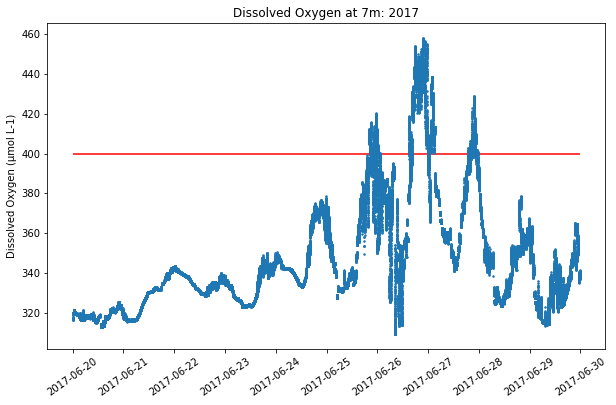

In [16]:
# plot shorter time range
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DO2017_data_sub['time'], DO2017_data_sub['estimated_oxygen_concentration'], '.', markersize=3)
ax.set_title('Dissolved Oxygen at 7m: 2017')
ax.set_ylabel('Dissolved Oxygen ({})'.format(DO2017_units['estimated_oxygen_concentration'][0]))

# plot a horizontal red line at the global max
plt.hlines(DO_global_max, np.nanmin(DO2017_data_sub['time']), np.nanmax(DO2017_data_sub['time']), colors='r')

# rotate x tick labels
plt.xticks(rotation=35);

We can see a pattern starting around 6/24 of a daily spike in dissolved oxygen that quickly goes above the global range. There's another annotation on a different Endurance dataset (CE09OSSM-RID27-04-DOSTAD000) that helps explain this a little bit better: "Evidence of increased oxygen during daylight hours suggest a phytoplankton layer has started to develop on the face of the instrument, producing oxygen as a result of photosynthesis". So these daily increases in dissolved oxygen are likely due to the same phenomenon - biofouling! The data from here until the end of the deployment (when the instrument is swapped out) are bad, likely from biofouling.

As the annotation on this dataset suggests, this deployment is prior the use of UV lamps for biofouling mitigation. Let's look at the 2019 dataset, which is after the implementation of the UV lamps.

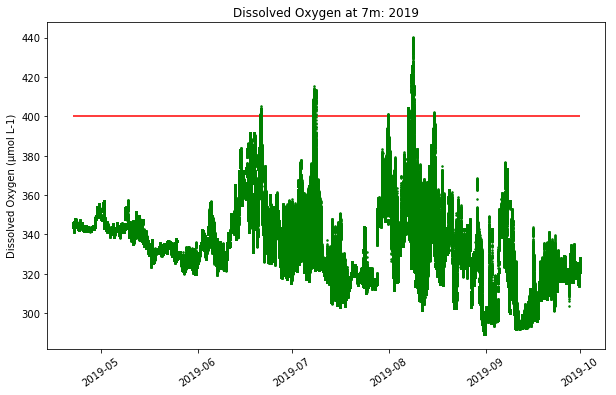

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DO2019_data['time'], DO2019_data['estimated_oxygen_concentration'], 'g.', markersize=3)
ax.set_title('Dissolved Oxygen at 7m: 2019')
ax.set_ylabel('Dissolved Oxygen ({})'.format(DO2019_units['estimated_oxygen_concentration'][0]))

# plot a horizontal red line at the global max
plt.hlines(DO_global_max, np.nanmin(DO2019_data['time']), np.nanmax(DO2019_data['time']), colors='r')

# rotate x tick labels
plt.xticks(rotation=35);

The patterns in this dataset look similar to the 2017 dataset - reasonable values in the beginning of the deployment, and more variable data starting in June with some values reaching above global ranges (although not as high as the values from 2017). Let's zoom in again to see if we can see the same daily pattern.

In [18]:
# subset dataframe for time period of interest
stime = np.datetime64('2019-06-15T00:00:00')
etime = np.datetime64('2019-06-22T00:00:00')
DO2019_data_sub = DO2019_data.loc[((DO2019_data['time'] > stime) & (DO2019_data['time'] < etime))]

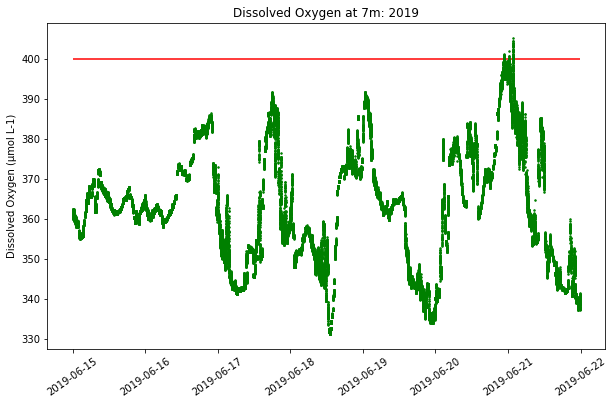

In [19]:
# plot shorter time range
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DO2019_data_sub['time'], DO2019_data_sub['estimated_oxygen_concentration'], 'g.', markersize=3)
ax.set_title('Dissolved Oxygen at 7m: 2019')
ax.set_ylabel('Dissolved Oxygen ({})'.format(DO2019_units['estimated_oxygen_concentration'][0]))

# plot a horizontal red line at the global max
plt.hlines(DO_global_max, np.nanmin(DO2019_data_sub['time']), np.nanmax(DO2019_data_sub['time']), colors='r')

# rotate x tick labels
plt.xticks(rotation=35);

Although not as pronounced, there is still somewhat of a daily spike of dissolved oxygen which suggests biofouling could be affecting this deployment as well, despite the mitigation. Let's take a look at the annotations again.

In [20]:
anno = annotations('CE04OSSM-RID27-04-DOSTAD000')
anno

,annotation,id,node,sensor,site,start,stop
0,The use of UV lamps has been implemented for biofouling mitigation on this instrument as of 2018-04-03T18:16:00Z.,2113.0,RID27,04-DOSTAD000,CE04OSSM,2018-04-03 18:16:00,None
1,"Prior to the use of UV lamps for biofouling mitigation, this sensor would routinely biofoul after the first 6-8 weeks of a deployment (more common during a spring/summer deployment). Users should carefully examine the data to determine if biofouling has begun to dominate the signal.",2105.0,RID27,04-DOSTAD000,CE04OSSM,2015-04-07 23:00:00,2018-04-03 18:16:00
2,"Due to a bug in the mooring telemetry system, data during this time range was not telemetered to shore. It was recorded on the mooring and instruments and will be available in the recovered data streams.",2181.0,None,None,CE04OSSM,2020-05-07 02:40:00,2020-05-12 00:00:00


The first annotation indicates that biofouling mitigation was implemented on April 3, 2018 and therefore should be in use for this deployment. There are no other annotations that indicate there were any issues with the biofouling mitigation, but these data still look suspect as they follow the same general pattern as the 2017 dataset that had some pretty obvious biofouling issues. Although it does appear to help since the DO values aren't quite as high/outside of global ranges, the UV light might not be completely preventing biofouling. The data after the first few weeks of the deployment. should still be considered suspect.

## Downsample and export
Now let's downsample the two datasets and export as .csv files.

In [21]:
DO2017_data = DO2017_data.rename(columns={'estimated_oxygen_concentration': 'Dissolved Oxygen ({})'.format(DO2017_units['estimated_oxygen_concentration'][0])})
DO2019_data = DO2019_data.rename(columns={'estimated_oxygen_concentration': 'Dissolved Oxygen ({})'.format(DO2019_units['estimated_oxygen_concentration'][0])})

In [22]:
# calculate minute averages for each dataframe
DO2017_minuteavg = DO2017_data.resample('T', on='time').mean().dropna(how='all').reset_index()
DO2019_minuteavg = DO2019_data.resample('T', on='time').mean().dropna(how='all').reset_index()

# round data to 2 decimal places
DO2017_minuteavg = DO2017_minuteavg.round(2)
DO2019_minuteavg = DO2019_minuteavg.round(2)

DO2017_minuteavg.head()

,time,Dissolved Oxygen (µmol L-1)
0,2017-04-22 00:00:00,344.84
1,2017-04-22 00:01:00,344.91
2,2017-04-22 00:02:00,344.99
3,2017-04-22 00:03:00,345.05
4,2017-04-22 00:15:00,344.92


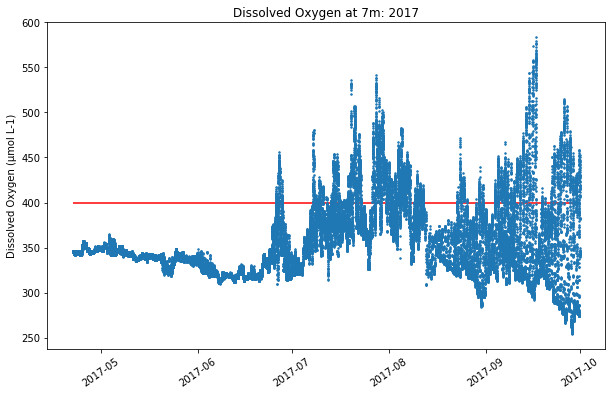

In [23]:
# plot the data again
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DO2017_minuteavg['time'], DO2017_minuteavg['Dissolved Oxygen (µmol L-1)'], '.', markersize=3)
ax.set_title('Dissolved Oxygen at 7m: 2017')
ax.set_ylabel('Dissolved Oxygen ({})'.format(DO2017_units['estimated_oxygen_concentration'][0]))

# plot a horizontal red line at the global max
plt.hlines(DO_global_max, np.nanmin(DO2017_minuteavg['time']), np.nanmax(DO2017_minuteavg['time']), colors='r')

# rotate x tick labels
plt.xticks(rotation=35);

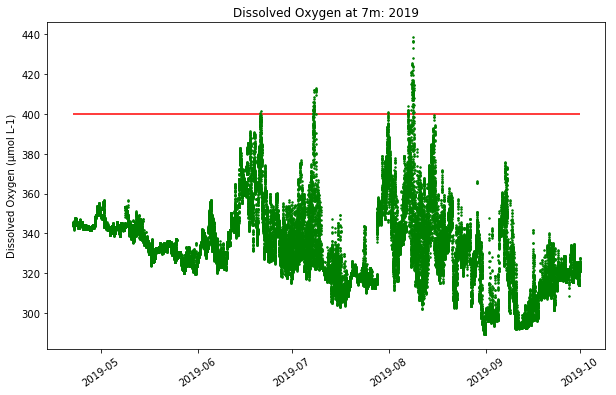

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(DO2019_minuteavg['time'], DO2019_minuteavg['Dissolved Oxygen (µmol L-1)'], 'g.', markersize=3)
ax.set_title('Dissolved Oxygen at 7m: 2019')
ax.set_ylabel('Dissolved Oxygen ({})'.format(DO2019_units['estimated_oxygen_concentration'][0]))

# plot a horizontal red line at the global max
plt.hlines(DO_global_max, np.nanmin(DO2019_minuteavg['time']), np.nanmax(DO2019_minuteavg['time']), colors='r')

# rotate x tick labels
plt.xticks(rotation=35);

In [25]:
# export the datasets to .csv
DO2017_minuteavg.to_csv(os.path.join(save_dir, 'E05_CE04OSSM_DO2017.csv'), index=False)
DO2019_minuteavg.to_csv(os.path.join(save_dir, 'E05_CE04OSSM_DO2019.csv'), index=False)